# 6. Multi-winner election

We've already seen how to create a **single winner election** with embedded voters. Now, I will explain how you can simulate **multi-winner** election on this framework. 

I will explains in detail what you can do with the multi-winner rules <tt>IterSVD()</tt> and <tt>IterFeatures()</tt>. If you are interested and want to implement your own multi-winner rule, you can check the doc and the code for the class <tt>IterRule()</tt>.

In [1]:
import embedded_voting as ev
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

## Create the profile

You should start to be familiar with this part of the notebook. As always, we are creating **a profile of embedded voters**. This time, we have $20$ candidates instead of $5$, because it enables us to see what our multi-winner rules really do.

To do so, I simply use the candidates from the profile of the **Notebook 2**, and duplicate them 3 times. The profile is as follows :

   * The **<font color="red">red group</font>** contains **50%** of the voters, and the average scores of candidates given by this group are $[0.9,0.3,0.5,0.2,0.2]$.
   * The **<font color="green">green group</font>** contains **30%** of the voters, and the average scores of candidates given by this group are $[0.2,0.6,0.5,0.3,0.9]$.
   * The **<font color="blue">blue group</font>** contains **20%** of the voters, and the average scores of candidates given by this group are $[0.2,0.6,0.5,0.9,0.3]$.
   
In that way, candidates $(0, 5, 10, 15)$ are candidates of the **<font color="red">red group</font>**, candidates $(4, 9, 14, 19)$ are candidates of the **<font color="green">green group</font>**, candidates $(3, 8, 13, 18)$ are candidates of the **<font color="blue">blue group</font>**, and all other candidates are more *"consensual"*.

In the following cell, I create my profile using <tt>ParametricProfile()</tt> :

In [2]:
scores_matrix_bloc = np.array([[.9, .3, .5, .3, .2], [.2, .6, .5, .3, .9], [.2, .6, .5, .9, .3]])
scores_matrix = np.concatenate([scores_matrix_bloc]*4, 1)

proba = [.5, .3, .2]

profile = ev.ParametricProfile(5*4, 3, 100, scores_matrix, proba)
profile.set_parameters(polarisation=0.6, coherence=0.8)

The following cell **displays the profile distribution**:

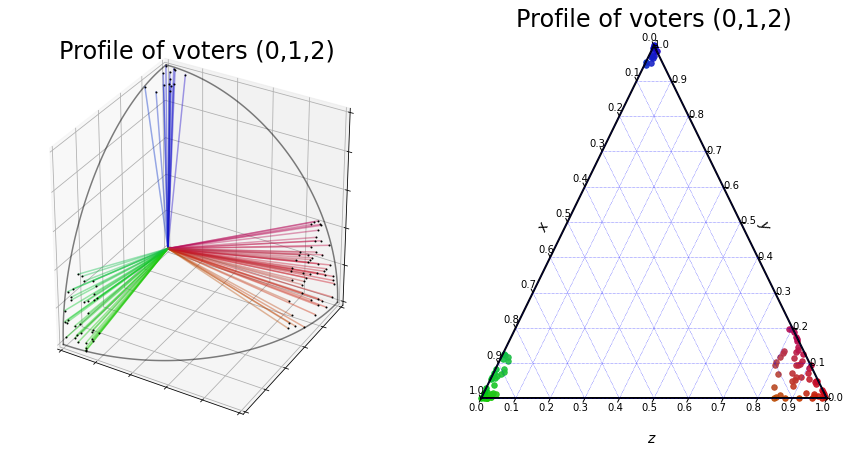

In [3]:
fig = plt.figure(figsize=(15,7.5))
profile.plot_profile("3D", fig=fig, position=[1,2,1], show=False)
profile.plot_profile("ternary", fig=fig, position=[1,2,2], show=False)
plt.show()

This cell displays **the candidates**. You can see that each column contains very similar candidates.

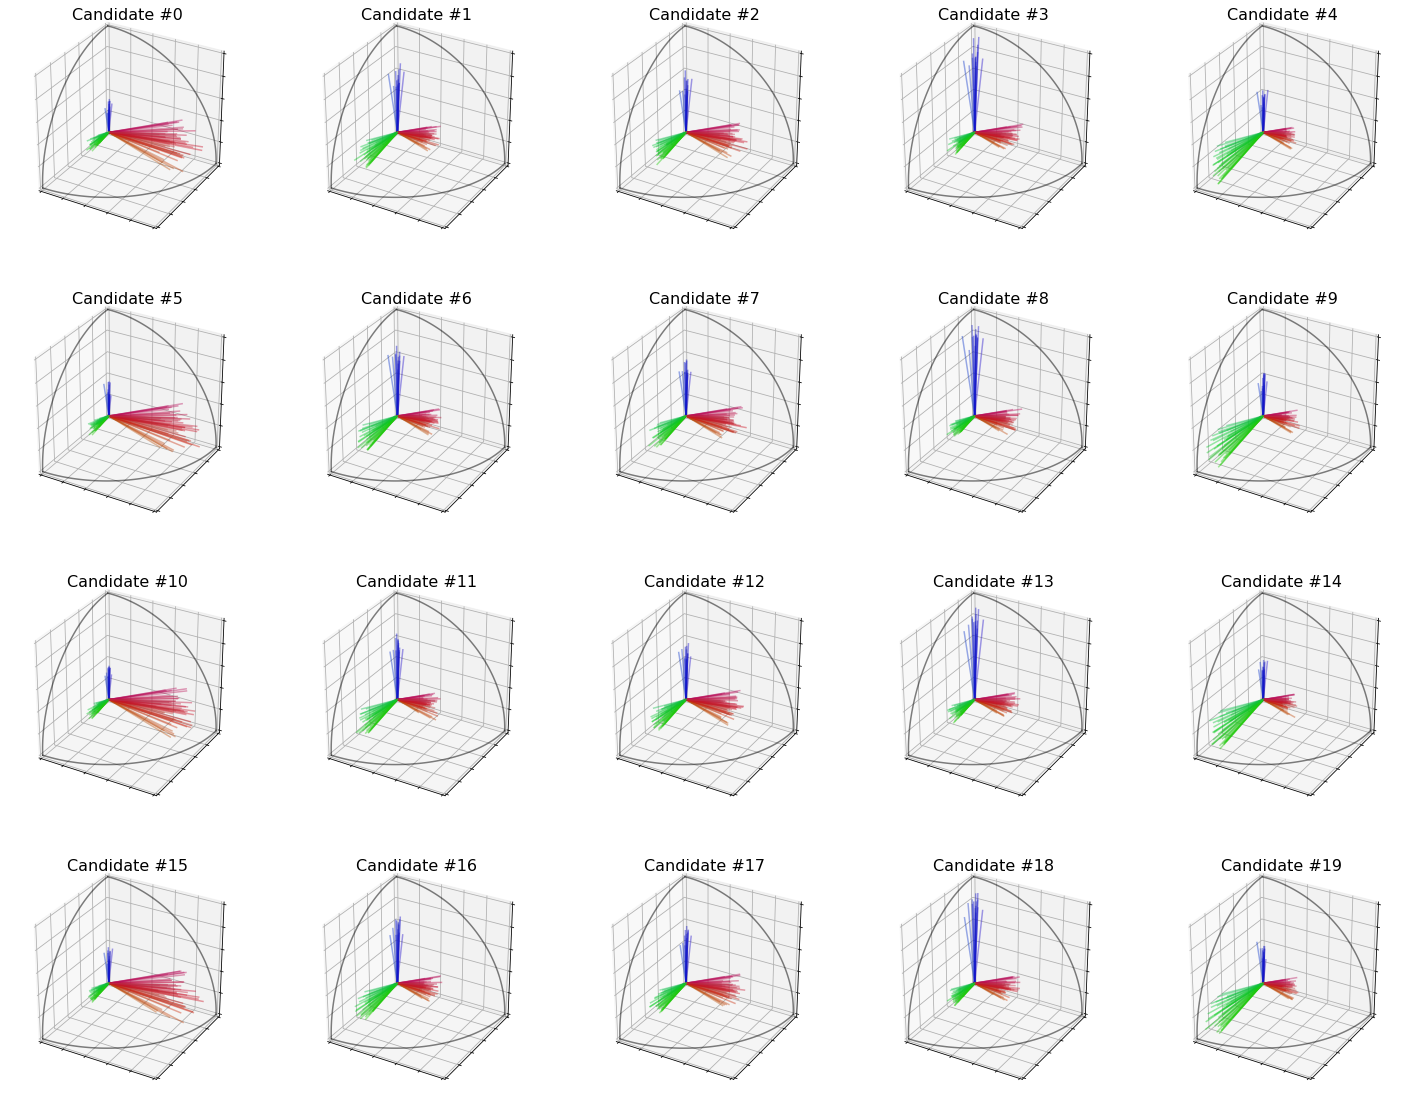

In [4]:
profile.plot_candidates("3D")

## How IterRule work (a bit of theory)

Our goal was to elaborate rules that respects the proportionality with respects to both **the scores and the embeddings** of the voters. That means that if a group of voter with similar embeddings represent $25\%$ of the population, $25\%$ of the winning committee should be composed of their **favorite candidates**

To do so, we implemented an adaptation of *Single Transferable Vote (STV)* to profiles with embedded voters. 

First, **some notations** :


| Notations   | Meaning               |
|-----------|-----------------------|
| $v_i$     | The $i^{th}$ voter    |
| $c_j$     | The $j^{th}$ candidate|
| $s_i(c_j)$| The score given by the voter $v_i$ to the candidate $c_j$|
| $M$       | The embeddings matrix, such that $M_i$ are the embeddings of $v_i$|
| $k$     | The size of the winning committee|
| $$0 \le t < k$$      | The iteration number   |
| $w_i(t)$   | The weight of voter $v_i$ at time $t$|
| $W(t)$   | The $t^{th}$ candidate of the winning committee|
| $sat_i(t)$   | The satisfaction of voter $v_i$ with candidate $W(t)$|


The rule we are using in this notebook are following this algorithm:

 * At the initialization, the weight of all voters is equal to $w_i(0) = 1$.
 * At each step $t \in [0, k-1[$ :
     * Apply a **voting rule** on the profile defined by the scores $(w_i \times s_i)$ and the embeddings matrix $M$. The voting rule should return a score and a feature vector for each candidate. Select the candidate $c$ not yet in the committee with the maximum score. This will be the winner $W(t)$. Let's denote $v(t)$ the feature vector of this candidate.
     * We compute **the satisfaction** of every voter with the new candidate, which is defined as 
     
     $$
     s_i(W(t)) \times \text{cos}(v(t),M_i)
     $$
     
       where $\text{cos}$ is the **cosine similarity**. Therefore, a voter with embeddings close to the candidate's features will be more satisfied than a candidate orthogonal to the features of the candidate.
     * **Update the weigths** of the voters according to their level of satisfaction. The sum of all the removed weights should be equal to **a quota** of voter, for instance $\frac{n}{k}$.
     
At the end, the weights of all voters should be close to $0$.

In this notebook, I will presents two rules based on this algorithms : **IterSVD** and **IterFeatures**.

   * **IterSVD** uses a *SVD based* rule presented on the notebook 2 to determine the scores of the candidates. The features vector is the vector of the *SVD* associated to the **largest singular value**. A very well-suited aggregation function to acheive proportionnality is the **maximum** function.
   * **IterFeatures** is based on the *Features* rule presented on the notebook 2. The notion of features vector is straightforward.
   
Now, let's see how it works!

## Run an election

The following cell show how you **instantiate a multi-winner election**. 

Here we want a committee of size $k=5$ and we are using the *classic* method of quota (see next section).

In [5]:
election = ev.IterSVD(profile, k=5, quota="classic")

You can immediatly **print** and **plot** the winning committee.

In our case, the committee contains $3$ candidates of the **<font color="red">red group</font>**, $2$ candidates of the **<font color="green">green group</font>** and $0$ of the **<font color="blue">blue group</font>**. This gives us proportion of $(40\%, 40\%, 20\%)$ instead of $(60\%, 40\%, 0\%)$.

Winners :  [5, 19, 10, 9, 15]


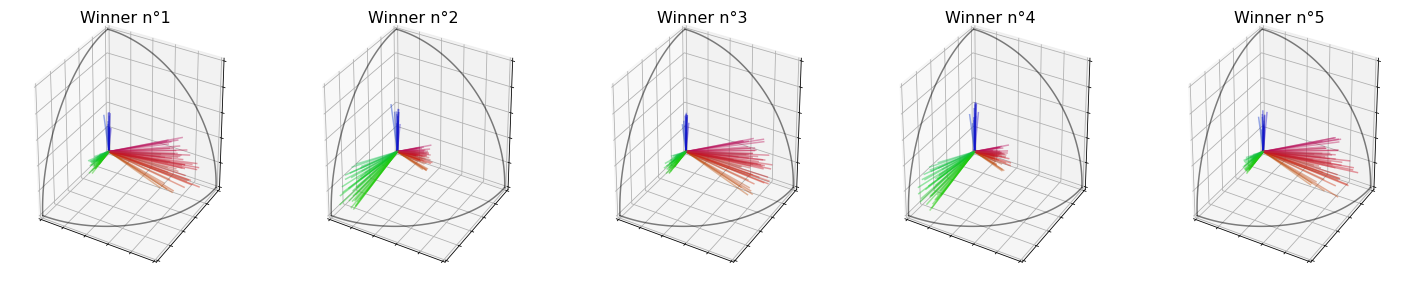

In [6]:
print("Winners : ",election.winners_)
election.plot_winners()

The following cell shows how to plot **the evolution of the voters' weights** with time. The black vector represent the **features vector** of the candidate selected at this step. 

For instance, the first candidate is liked by the **red group**, so its vector is very similar to the vectors of voters in this group, and you can see that the weight of every voter of this group is reduced on step 2.

Weight / remaining candidate :  [20.0, 20.000000000000004, 19.999999999999996, 19.999999999999996, 20.48549074634844]


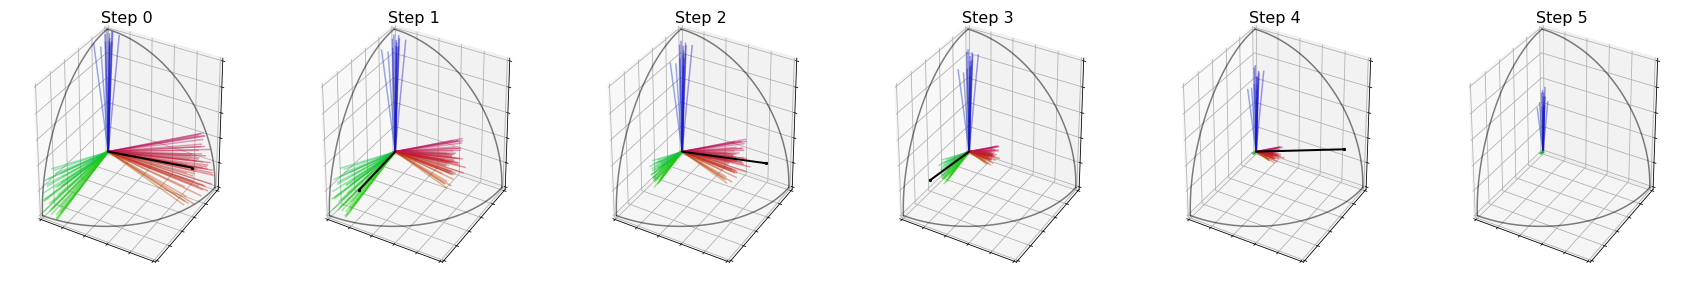

In [7]:
election.plot_weights(row_size=6)

## Changing some parameters

You can change the method of quota using the function <tt>set_quota()</tt>. There is two possible quotas: 

  * *Classic* quota $Q = \frac{n}{k}$.
  * *Droop* quota $Q = \frac{n}{k+1} + 1$.
  
However, there is **not a big difference** between the results if we use on quota or another. For instance, with $k=5$, we obtains the **same comittee** as before:

Winners :  [5, 19, 10, 9, 15]


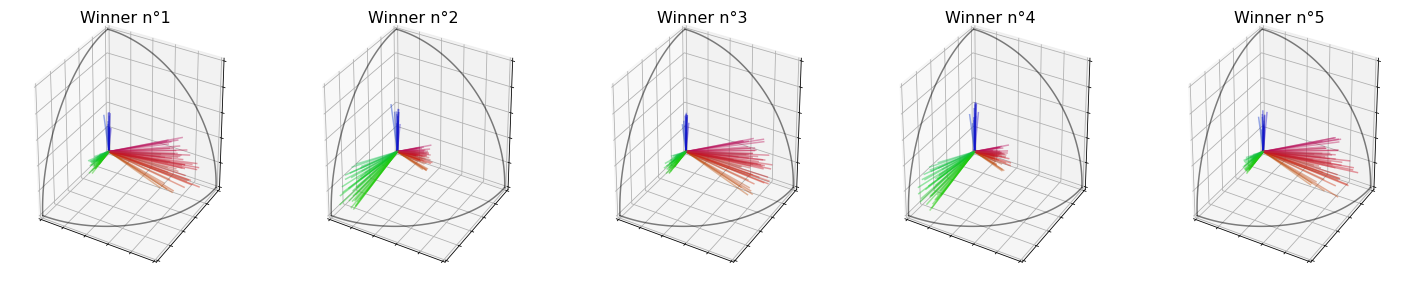

In [8]:
election.set_quota("droop")
print("Winners : ",election.winners_)
election.plot_winners()

You can also change parameters related to the *SVD*, for instance the **square_root** parameter, which can change the results.

Indeed, as you can see on the following cell, when we are not taking the square root, we **give more opportunities to small groups** (like the group of blue voters).

Winners :  [5, 19, 10, 8, 9]


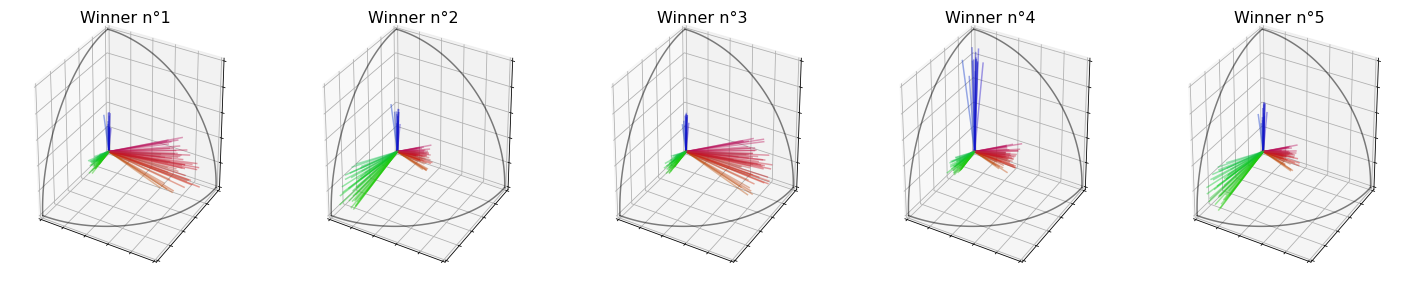

In [9]:
election = ev.IterSVD(profile, k=5, quota="classic", square_root=False)
print("Winners : ",election.winners_)
election.plot_winners()

## Changing the size of the committee

You can **change the size** of the winning committee, by calling the function <tt>set_k()</tt>.

As you can see, if we set the size of the comittee to $k=11$ candidates, There are $4$ candidates of the **<font color="red">red group</font>** (that is the maximum possible), there are also $4$ candidates of the **<font color="green">green group</font>**, and $2$ candidates of the **<font color="blue">blue group</font>**. The last candidate *(actually Winner 10)* is a *consensual* candidates. 

The **proportions obtained** are close to the real proportions $(50\%, 30\%, 20\%)$.

Winners :  [5, 10, 19, 15, 9, 0, 4, 8, 2, 14, 3]


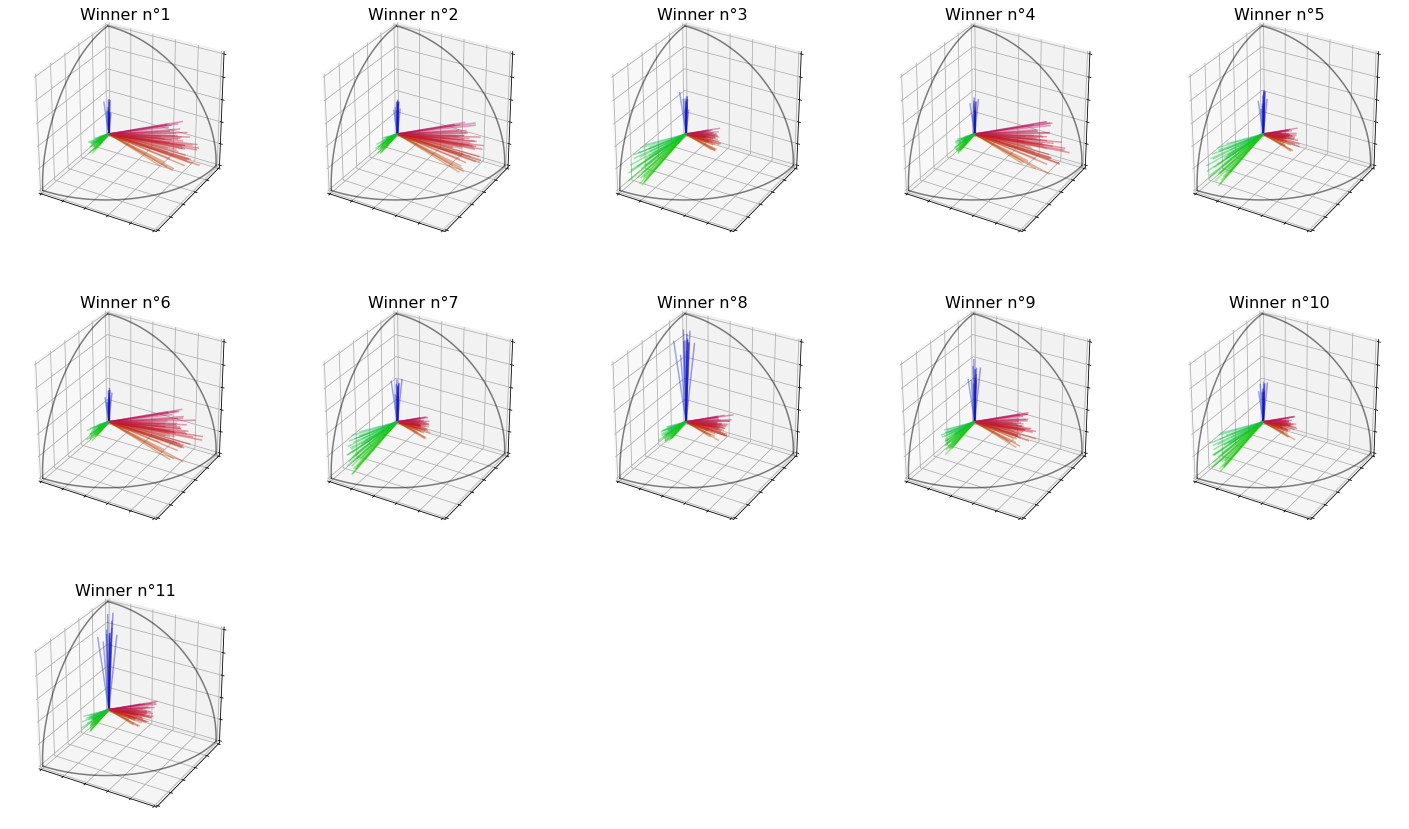

In [10]:
election = ev.IterSVD(profile)
election.set_k(11)
print("Winners : ",election.winners_)
election.plot_winners()

As before, we can displays the evolutions of **the weights** of the voters, with the feature of the selected candidate at each step in **black**. In the end, all weigths are almost $0$.


Weight / remaining candidate :  [9.090909090909092, 9.090909090909092, 9.090909090909088, 9.09090909090909, 9.09090909090909, 9.09090909090909, 9.09090909090909, 9.090909090909088, 9.090909090909088, 9.090909090909086, 9.517040618289515]


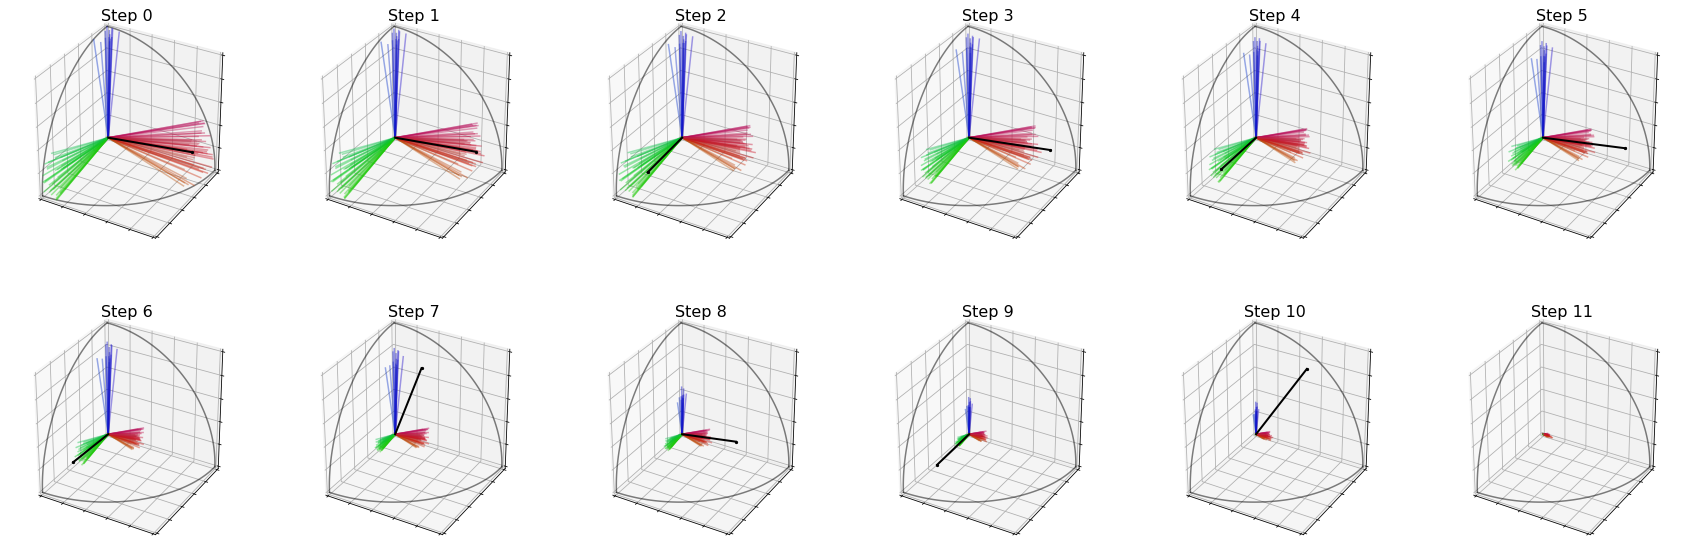

In [11]:
election.plot_weights(row_size=6)

## Using other SVD Rules

You can use another rule than **the maximum** for the <tt>IterSVD()</tt> function. However, the maximum is well suited for proportionnality, which is not the case for other aggregation functions. For instance, with **the product**, we only obtains *consensual* candidates, as it is shown in the following cell:

Winners :  [2, 6, 7, 16, 12, 17]


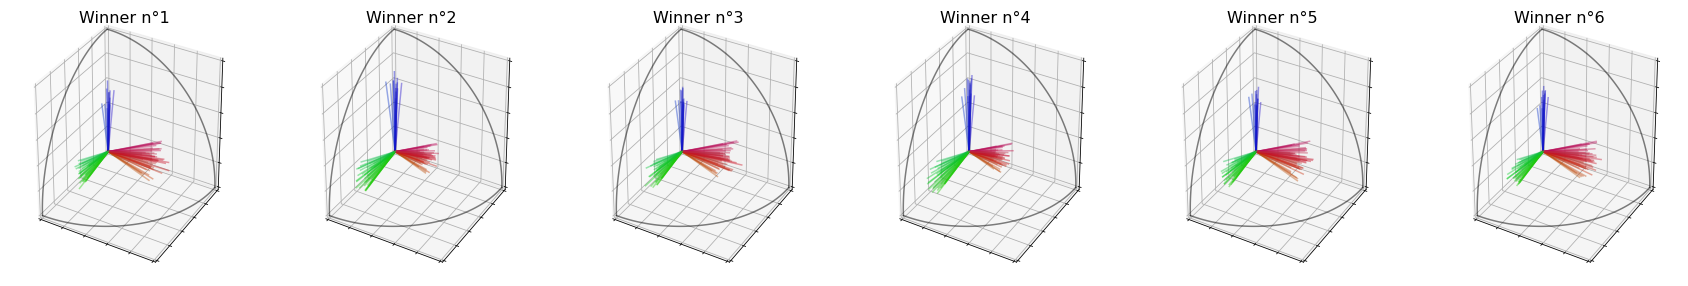

In [12]:
election = ev.IterSVD(profile, k=6, quota="classic", aggregation_rule=np.prod)
print("Winners : ",election.winners_)
election.plot_winners(row_size=6)

Weight / remaining candidate :  [16.666666666666668, 16.666666666666664, 16.666666666666668, 16.666666666666664, 16.666666666666664, 16.666666666666657]


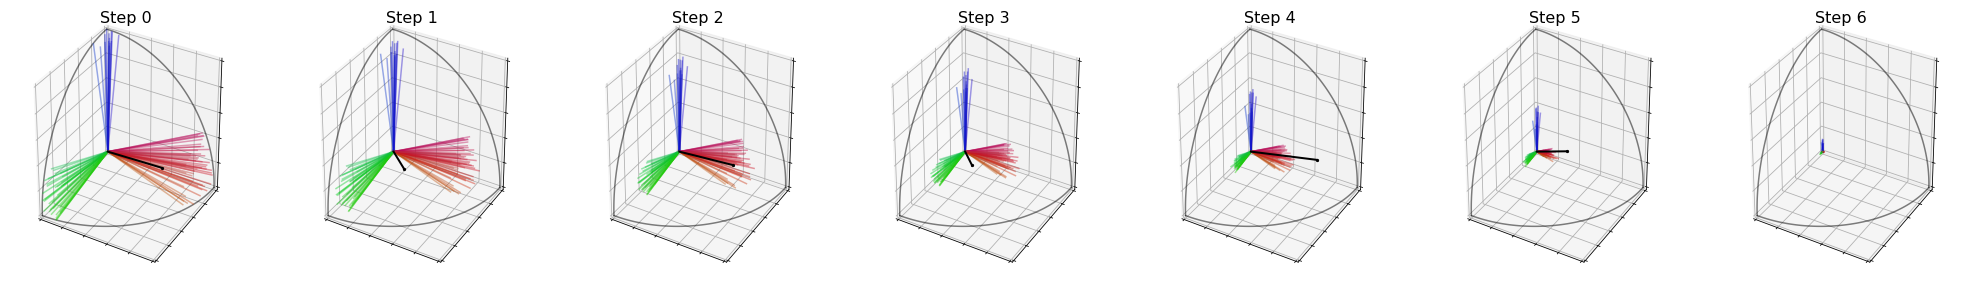

In [13]:
election.plot_weights(row_size=7)

## IterSVD versus IterFeatures

Everything I explained earlier for **IterSVD** also works for **IterFeatures**. Let's see how the two rules compare on some examples:

In [14]:
election_svd = ev.IterSVD(profile, k=5)
election_features = ev.IterFeatures(profile, k=5)

With $k=5$, the proportions achieved by **IterFeatures** are $(40\%, 40\%, 20\%)$, which is more egalitarian than the $(60\%, 40\%, 0\%)$ achieved by **IterSVD**. It is due to the fact that **IterSVD** takes into account the size of each each group to choose a winner but not **IterFeatures**. For the latter, the size of the group only appears to update the weights of the voters.

Winners (SVD) :  [5, 19, 10, 9, 15]


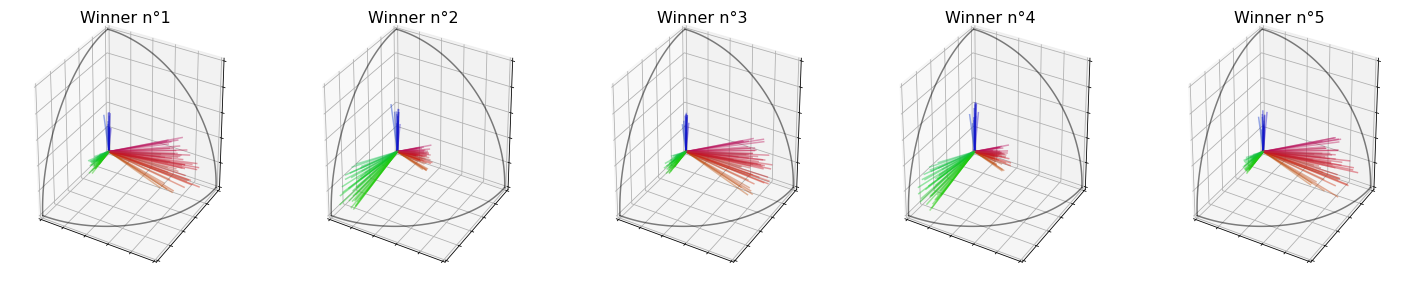

Winners (Features) :  [19, 5, 8, 10, 9]


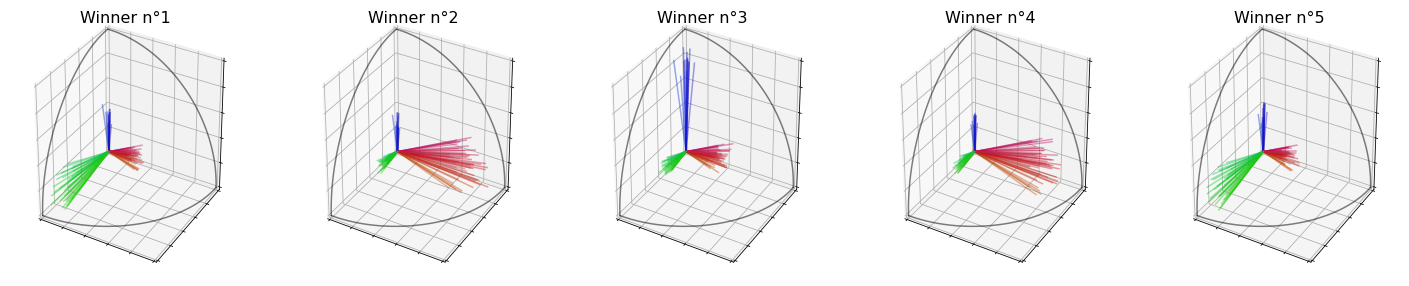

In [15]:
print("Winners (SVD) : ",election_svd.winners_)
election_svd.plot_winners()
print("Winners (Features) : ",election_features.winners_)
election_features.plot_winners()

It is even clearer with $k=11$. As you can see on the following cells, the first two candidates selected by **IterFeatures** are a green and a blue candidates, even if the red group is bigger.

In [16]:
election_svd.set_k(11)
election_features.set_k(11)

Winners (SVD) :  [5, 10, 19, 15, 9, 0, 4, 8, 2, 14, 3]


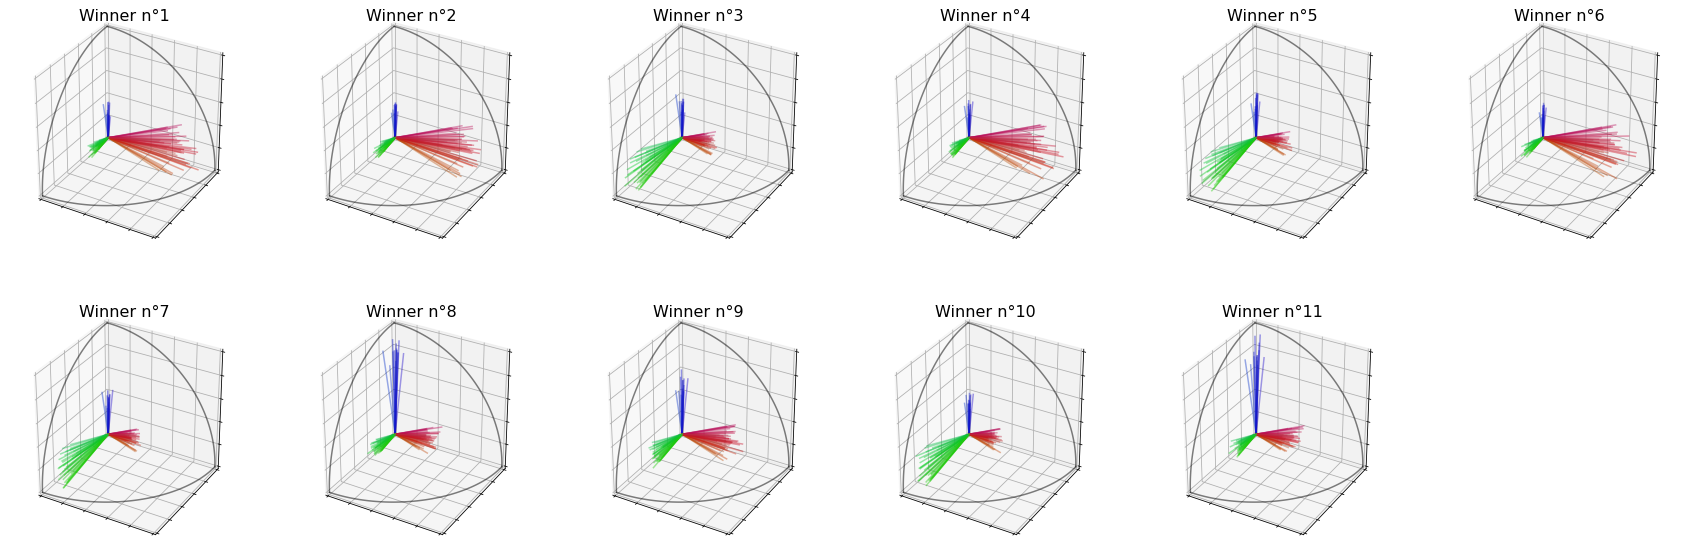

Winners (Features) :  [19, 8, 5, 9, 10, 18, 0, 14, 15, 13, 4]


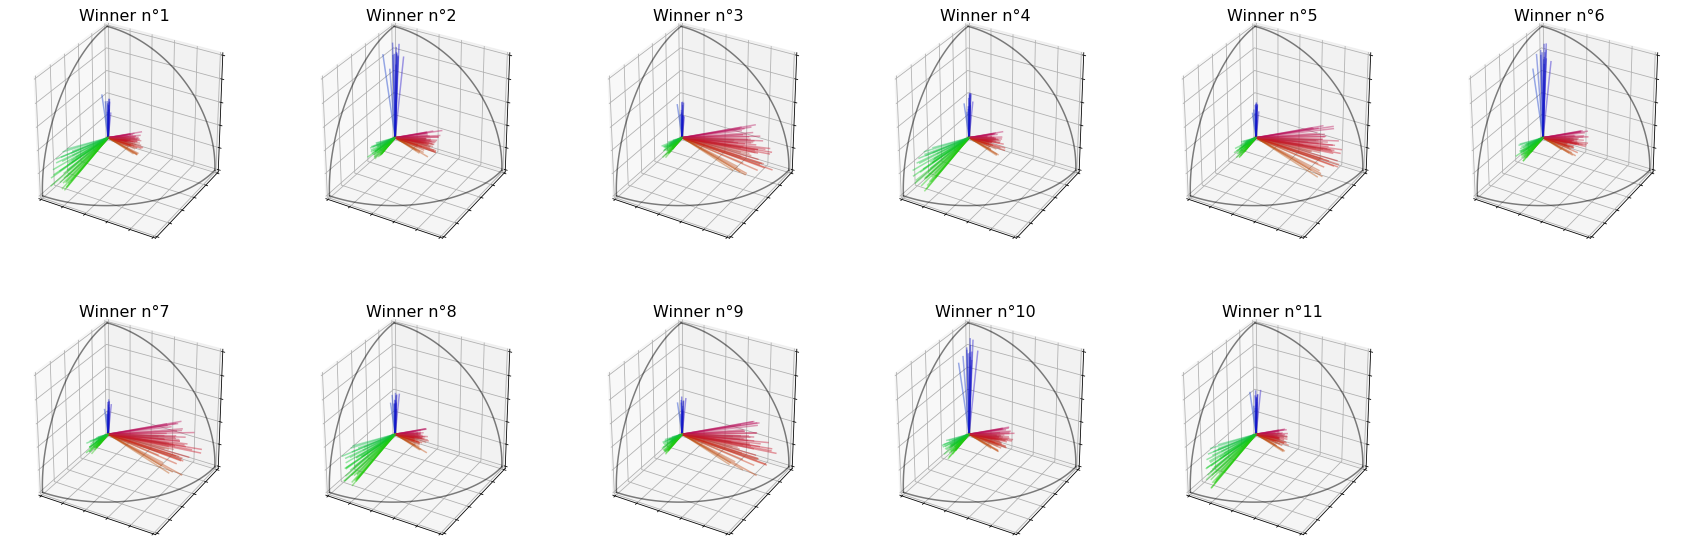

In [17]:
print("Winners (SVD) : ",election_svd.winners_)
election_svd.plot_winners(row_size=6)
print("Winners (Features) : ",election_features.winners_)
election_features.plot_winners(row_size=6)

IterSVD


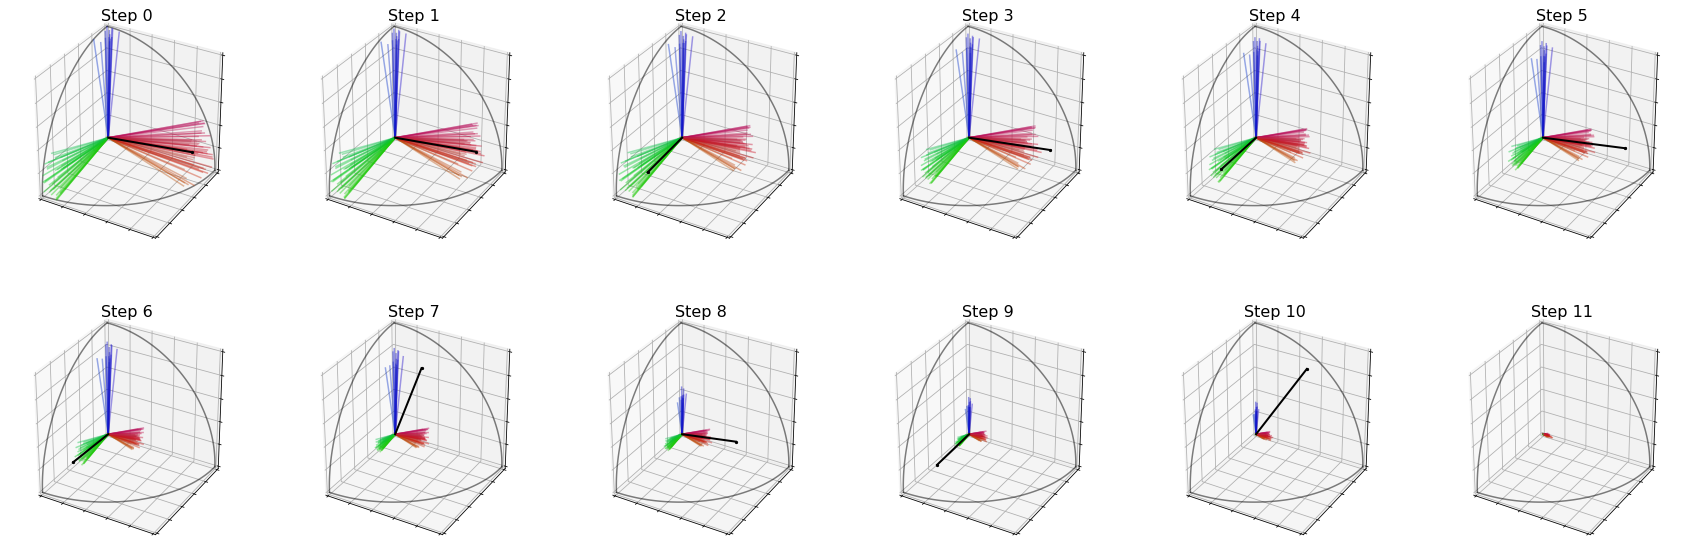

IterFeatures


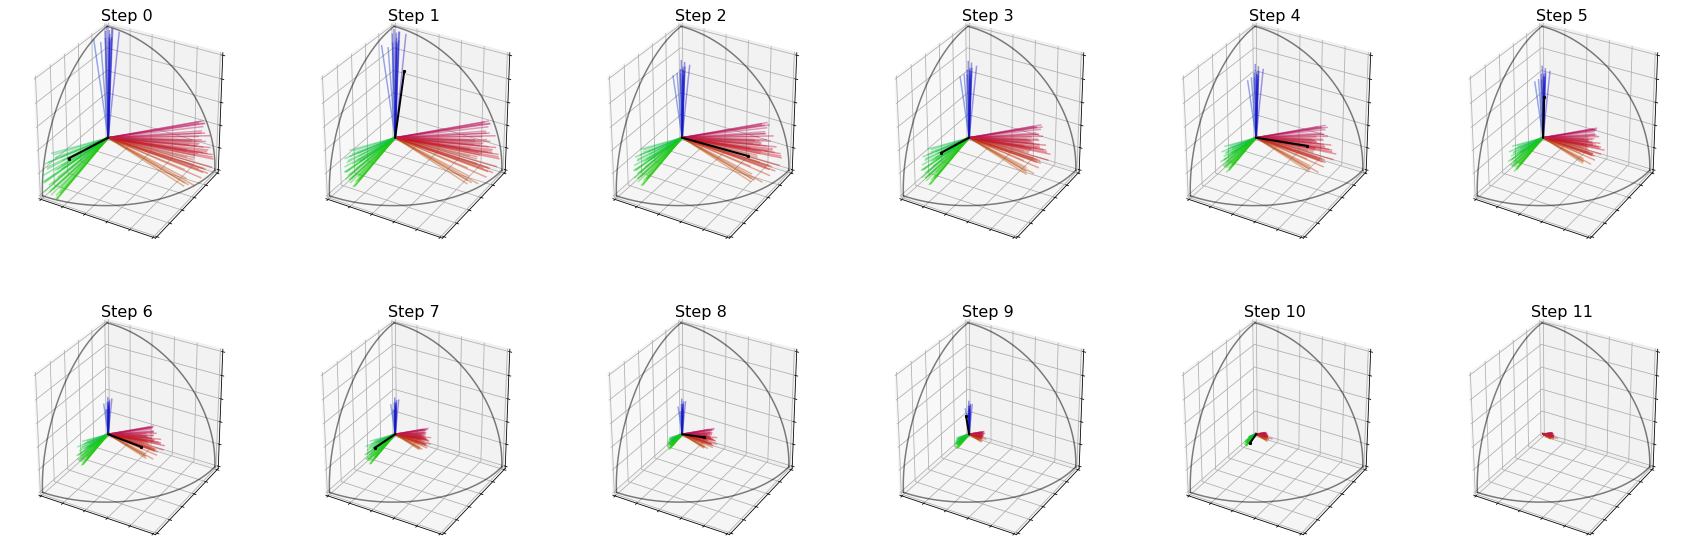

In [18]:
print("IterSVD")
election_svd.plot_weights(row_size=6, verbose=False)
print("IterFeatures")
election_features.plot_weights(row_size=6, verbose=False)